<a href="https://colab.research.google.com/github/UPstartDeveloper/DS-2.4-Advanced-Topics/blob/main/Notebooks/NLP/Stack_Overflow_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What Language is It? 
## Text Classification of Stack Overflow Questions, using Keras 

Originally adapted from the botton of [this tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb) on binary text classification from Tensorflow. The original notebook stated:

> ### Exercise: multiclass classification on Stack Overflow questions

> This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multiclass classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

> We have prepared a [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

> The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

> After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

> ```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

> Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

> To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

> 1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

> 2. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

> 3. When you compile your model, change the loss to `losses.SparseCategoricalCrossentropy`. This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

> 4. Once these changes are complete, you will be able to train a multiclass classifier. 

> If you get stuck, you can find a solution [here](https://github.com/tensorflow/examples/blob/master/community/en/text_classification_solution.ipynb).


## Importing Packages

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## What Version of Tensorflow is This?

In [4]:
print(tf.__version__)

2.4.0


## Download and Explore the Stack Overflow Dataset

In [5]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

# adds a dir for the dataset
dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

# getting the full path to the directory
dataset_dir = os.path.join(os.path.dirname(dataset))

6053888/6053168 [==============================] - 0s 0us/step


In [6]:
# listing all the sub paths in the dataset's ZIP folder
os.listdir(dataset_dir)

['.config',
 'test',
 'stack_overflow_16k.tar.gz.tar.gz',
 'train',
 'README.md',
 'sample_data']

In [7]:
# do the same just for the training data directory
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'javascript', 'java', 'python']

**Example Data**:
Let's take a look at one of the questions for Python.

In [8]:
sample_file = os.path.join(train_dir, 'python/102.txt')
with open(sample_file) as f:
  print(f.read())

"why not use self.varibale_name while calling instance attribute when we create a class which is having instance attribute,why don't we call the instance attribute using self keyword.please..class car:.    def __init__(self, type, color):.        self.type = type.        self.color = color...c1 = car('suv','red').print(c1.type)...why not print(c1.self.type), because self.type is the actual attribute..got the following error:..attributeerror: 'car' object has no attribute 'self'"



## Load the dataset

In this step we'll do a number of things to prepare the data for text classification including:

1.   Loading the data using `tf.data.Dataset` ([docs](https://www.tensorflow.org/guide/data))
2.   Splitting the data into training, validation, and testing sets

For now, let's find our training data:



In [9]:
batch_size = 32
seed = 42

# creating trainin
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training',  # let's take the other 80% of the training data
    seed=seed)  # use the same seed or don't shuffle, to guarantees no overlap 

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [10]:
# generate 1 batch (as an example)
for text_batch, label_batch in raw_train_ds.take(1):
  # show the review and the review of 3 samples from the batches
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

### What Do the Labels Mean?
Let's use Tensorflow to find out what classes they correspond to.

In [11]:
# note that raw_train_ds is a kind of Tensorflow-defined object called a BatchGenerator
# and it works similar to like a normal generator that comes built-in to Python
for label in range(4):
  print(f"Label {label} corresponds to {raw_train_ds.class_names[label]}")  

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


### Find the Validation and Testing sets to use from the Dataset

In [12]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [13]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


## Preprocess the dataset

In [14]:
def custom_standardization(input_data):
  """This function came from the original Tensorflow notebook: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb
     It allows us to strip HTML text (if present) from our input data.
  """
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [15]:
# creating a TextVectorization layer
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

And remember, only use the training data for this step!

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
  """
  See the result of using this layer to preprocess some data.
  This function came from the original Tensorflow notebook: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb
  """
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 questions and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
# this dict maps the binary label to the actual class name
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3, 

As a final preprocessing step, we apply the TextVectorization layer created earlier to the train, validation, and test dataset.

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [21]:
embedding_dim = 16  

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),  # Q: what's an embedding vector?
  layers.Dropout(0.2),  # drop out = let's prevent overfitting
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)]) # number of neurons = number of labels

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


## Compile the Model
Add a loss function and optimizer

In [24]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train the Model

In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 4s 17ms/step - loss: 1.3837 - binary_accuracy: 0.2627 - val_loss: 1.3670 - val_binary_accuracy: 0.2455
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3585 - binary_accuracy: 0.2505 - val_loss: 1.3254 - val_binary_accuracy: 0.2439
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3107 - binary_accuracy: 0.2547 - val_loss: 1.2628 - val_binary_accuracy: 0.2448
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2423 - binary_accuracy: 0.2529 - val_loss: 1.1905 - val_binary_accuracy: 0.2453
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1686 - binary_accuracy: 0.2535 - val_loss: 1.1192 - val_binary_accuracy: 0.2439
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0961 - binary_accuracy: 0.2548 - val_loss: 1.0510 - val_binary_accuracy: 0.2442
Epoch 7/10
200/200 [==============================] - 1s 5ms/st

## Evaluate the model

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.8693 - binary_accuracy: 0.2513
Loss:  0.8693167567253113
Accuracy:  0.2512812614440918


## Create a plot of accuracy and loss over time

In [27]:
history_dict = history.history
history_dict.keys()  # these come the metrics we specified during compilation

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

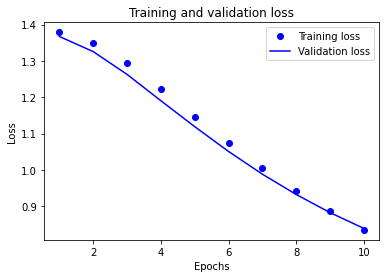

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

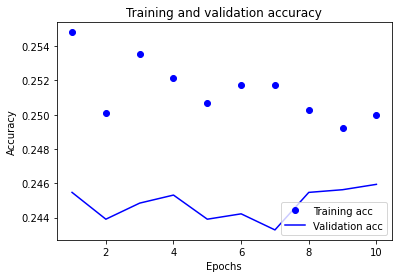

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')  # why do we need this? doesn't the model already have an activation layer?
])

export_model.compile( # needs the same loss function as before, b/c it's for the same use case
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 12ms/step - loss: 0.8707 - accuracy: 0.7315
0.7352499961853027


## Inference on New Data

In [32]:
examples = [
  "So how come this gives a TypeError?"
]

export_model.predict(examples)

array([[0.49628377, 0.446131  , 0.5544726 , 0.49759176]], dtype=float32)